# Visualization for Delegation Based Lock

In [9]:
@time using DataFrames, CSV

bench = @time CSV.read("output/output_nc_10ns.csv", DataFrame)
bench.Locktype = first.(split.(bench.Locktype, "|"))


  0.004472 seconds (903 allocations: 60.664 KiB)


ArgumentError: ArgumentError: "output/output.csv" is not a valid file or doesn't exist

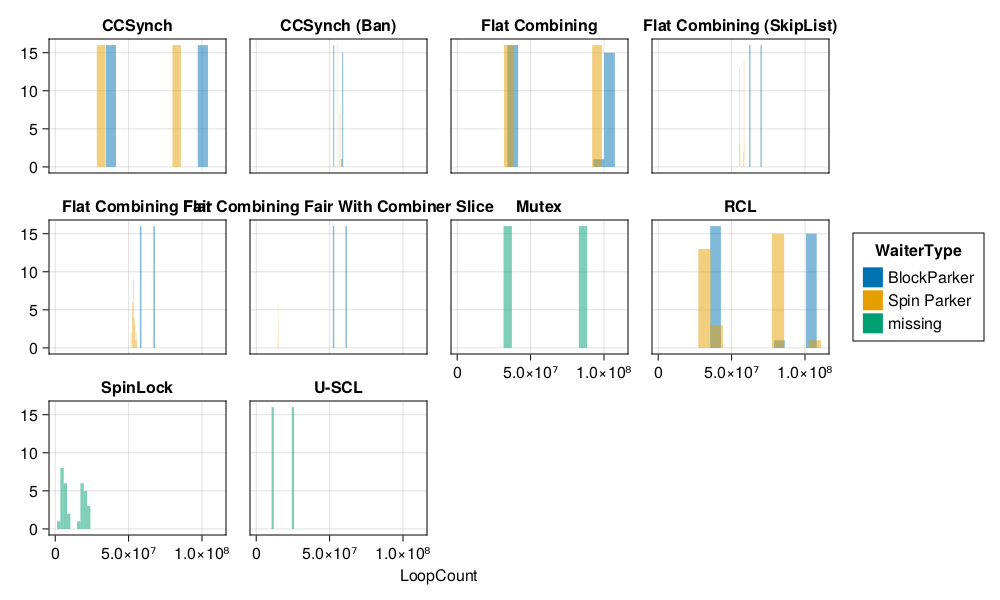

CairoMakie.Screen{IMAGE}


In [10]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")

loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 32)
end) |> data) * mapping(:LoopCount, layout = :Locktype, color = :WaiterType => nonnumeric) * (visual(Hist, bins=10, alpha=0.5))
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
fig = draw(loop_comparison, figure=(resolution=(1000,600),))

save("graphs/loop_comparison_per_thread_histogram.svg", fig)

display(fig)

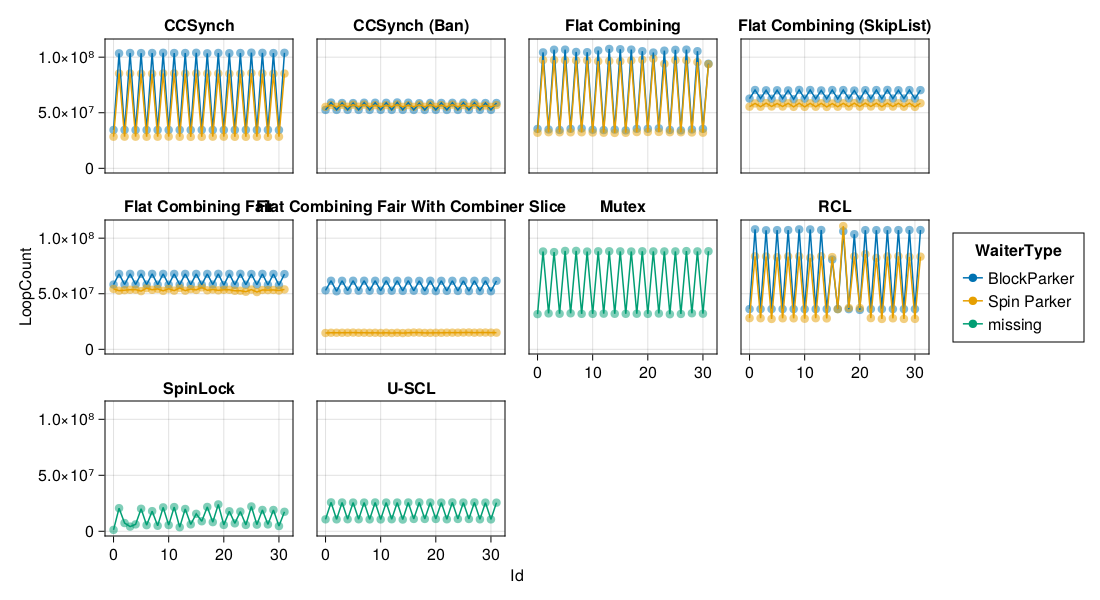

CairoMakie.Screen{IMAGE}


In [11]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")


loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 32)
end) |> data) * mapping(:Id, :LoopCount, layout = :Locktype, color = :WaiterType) * (visual(Scatter, alpha = 0.5) + visual(Lines))
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
fig = draw(loop_comparison, figure = (resolution = (1100,600),))

save("graphs/loop_comparison_per_thread.svg", fig)

display(fig)

In [12]:
using AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density
using Tidier

CairoMakie.activate!(type = "svg")


loop_comparison = ((@chain bench begin
        Tidier.@filter(ThreadNum == 16 && Locktype == "CCSynch" && WaiterType == "Spin Parker")
end) |> data) * mapping(:Id, :LoopCount, layout = :Locktype, color = :WaiterType, marker = :WaiterType) * (visual(Scatter, alpha = 0.5) + visual(Lines))
    
# savefig(loop_comparison, "graphs/loop_comparison.svg")
fig = draw(loop_comparison, figure = (resolution = (1100,600),))

save("graphs/ccsynch_loop_comparison_per_thread.svg", fig)

display(fig)

In [ ]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, WaiterType, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, marker = :Locktype, color = :Locktype, layout = :WaiterType) * (visual(Lines, alpha=0.5) + visual(Scatter, alpha=0.5))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison_together.svg", fig)

display(fig)

In [ ]:
using Tidier
using AlgebraOfGraphics, CairoMakie

bench2 = @chain bench begin
    @group_by(Locktype, WaiterType, ThreadNum)
    @summarise(LoopCount = sum(LoopCount))
    @ungroup
end

plt = data(bench2) * mapping(:ThreadNum, :LoopCount, layout = :Locktype, color = :WaiterType) * (visual(Lines) + visual(Scatter))

fig = draw(plt, figure = (resolution=(1200,600),))

save("graphs/loop_comparison_split.svg", fig)

display(fig)

In [ ]:
using DataFrames, Tidier, AlgebraOfGraphics, CairoMakie

bench_32thread = @chain dropmissing(bench) begin
    Tidier.@filter(ThreadNum == 32)
end

plt = data(bench_32thread) * mapping(:Locktype, :CombineTime, layout = :WaiterType) * (visual(BoxPlot) + (visual(Scatter, color = "lightblue", strokewidth = 1 )))


fig = draw(plt, axis=(xticklabelrotation=pi/5,), figure = (resolution=(1000,600),))

save("graphs/combining_time_box_plot.svg", fig)

display(fig)

Dict{String, Any} with 9 entries:
  "cpu_num"        => 16
  "thread_num"     => 16
  "waiter_type"    => ""
  "hold_time"      => Dict{String, Any}("secs"=>0, "nanos"=>6211097)
  "combine_time"   => nothing
  "id"             => 0
  "response_times" => Any[52231041, 10583, 11578732, 10609, 38350940, 10665, 11…
  "locktype"       => "Mutex"
  "cpu_id"         => 0

In [ ]:
using JSON, DataFrames

files = readdir("output/response_times")

response_times_data = DataFrame(locktype=String[], waiter_type=Union{String,Missing}[], cpu_id=String[], thread_num=String[], response_time=Int[], is_combiner=Bool[])

for file in files

    # name = splitext(file)[1]

    # infos = split(name, "-")
    # locktype = infos[1]
    # waiter_type = infos[2] == "" ? nothing : infos[2]
    # num_cpu = infos[3]
    # num_thread = infos[4]

    datas = JSON.parsefile("output/response_times/$file")

    for data in datas
        for (time, is_combining) in zip(data["response_times"], data["is_combiner"])
            push!(response_times_data,
                (data["locktype"], data["waiter_type"] == "" ? missing : data["waiter_type"],
                    string(data["id"]),
                    lpad(data["thread_num"], 2, "0"),
                    time,
                    is_combining))
        end
    end
end

response_times_data

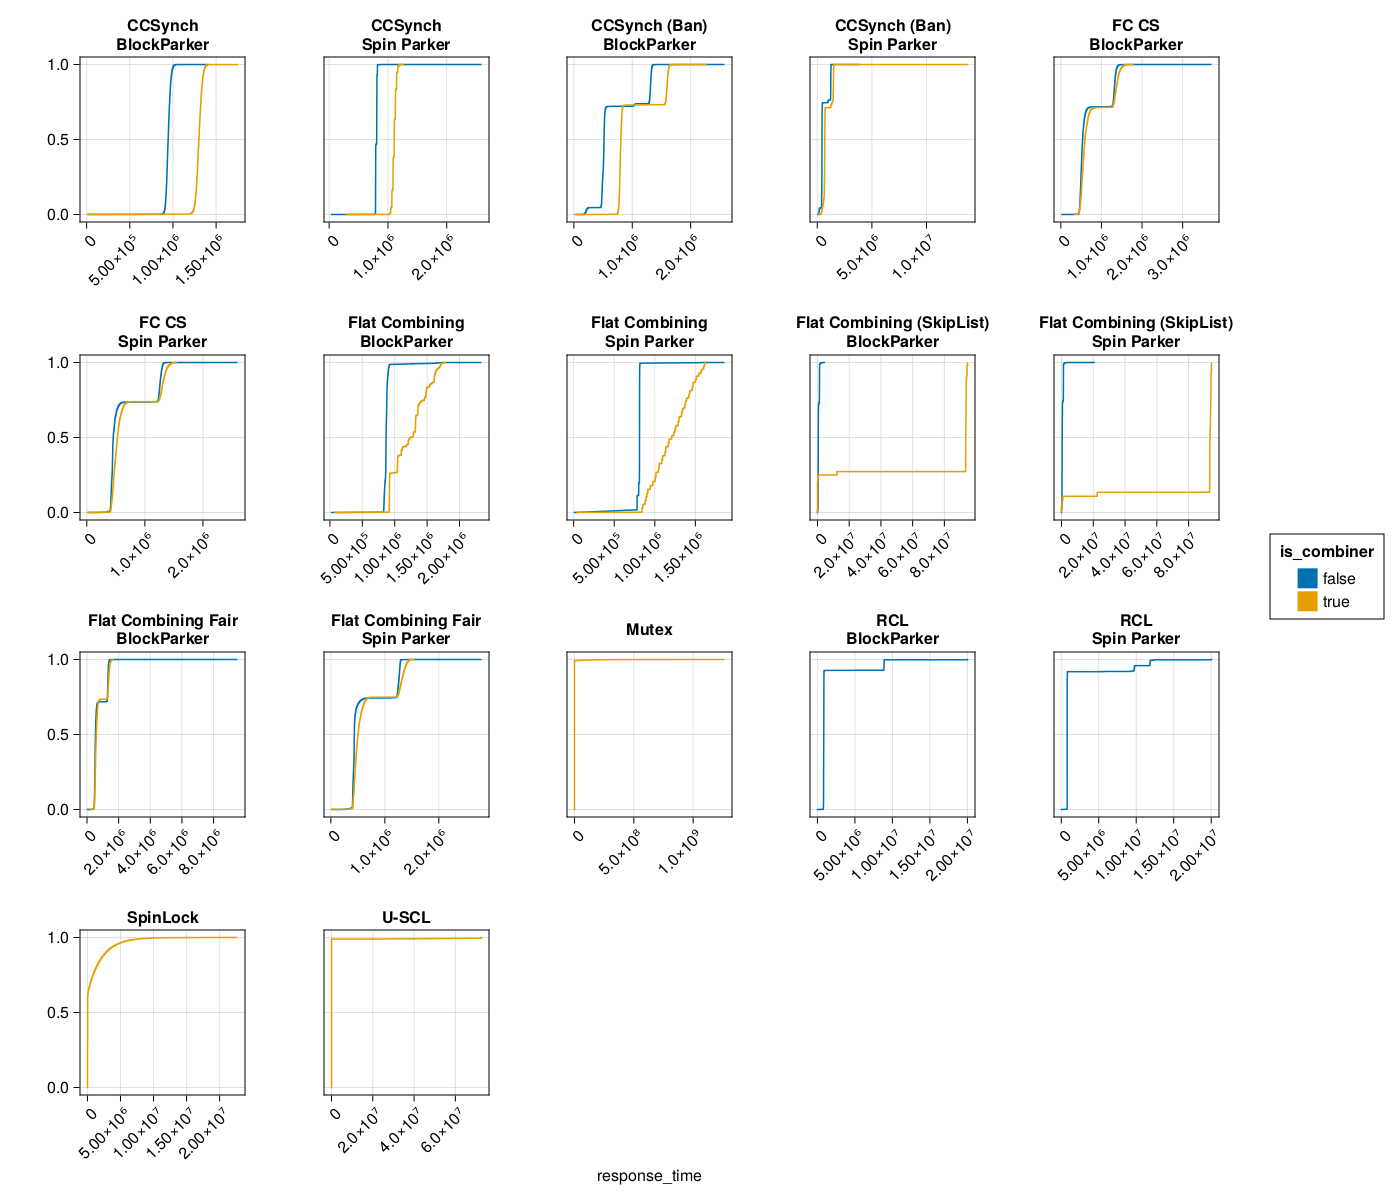

In [99]:
using Tidier, AlgebraOfGraphics, CairoMakie
using AlgebraOfGraphics: density

data1 = @chain response_times_data begin
    Tidier.@filter(thread_num == "40")
end

plt = data(data1) *
    mapping(:response_time, color=:is_combiner, layout=((:locktype, :waiter_type) => ((l,w)-> begin
        w = ismissing(w) ? "" : w
        l = replace(l, "Flat Combining Fair With Combiner Slice" => "FC CS")
        "$l\n$w"
    end ) => "lock")) * 
    visual(ECDFPlot)

response_time_plt = draw(plt, figure=(resolution=(1400, 1200),), facet=(; linkxaxes=:none), axis = (aspect = 1, xticklabelrotation = pi/4,))

save("graphs/response_time_ecdf.svg", response_time_plt)

response_time_plt